In [6]:
import jax

jax.config.update("jax_compilation_cache_dir", "jax-caches")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [7]:
from desc import set_device

set_device("mps")

In [8]:
from desc.io import load

eqfam = load("precise_QA_output.h5")
eq = eqfam[-1]

In [9]:
from desc.continuation import solve_continuation_automatic

eq = solve_continuation_automatic(eq, verbose=0)[-1]

/Users/leoduan/.pyenv/versions/3.12.12/lib/python3.12/site-packages/desc/objectives/utils.py:481: RuntimeWarning: divide by zero encountered in matmul
  b[unfixed_rows] - A[unfixed_rows][:, fixed_idx] @ b[fixed_rows],
/Users/leoduan/.pyenv/versions/3.12.12/lib/python3.12/site-packages/desc/objectives/utils.py:481: RuntimeWarning: overflow encountered in matmul
  b[unfixed_rows] - A[unfixed_rows][:, fixed_idx] @ b[fixed_rows],
/Users/leoduan/.pyenv/versions/3.12.12/lib/python3.12/site-packages/desc/objectives/utils.py:481: RuntimeWarning: invalid value encountered in matmul
  b[unfixed_rows] - A[unfixed_rows][:, fixed_idx] @ b[fixed_rows],
/Users/leoduan/.pyenv/versions/3.12.12/lib/python3.12/site-packages/desc/objectives/utils.py:481: RuntimeWarning: divide by zero encountered in matmul
  b[unfixed_rows] - A[unfixed_rows][:, fixed_idx] @ b[fixed_rows],
/Users/leoduan/.pyenv/versions/3.12.12/lib/python3.12/site-packages/desc/objectives/utils.py:481: RuntimeWarning: overflow encountered 

(<Figure size 576.303x576.303 with 2 Axes>,
 <Axes: title={'center': '$|\\mathbf{B}|~(T)$'}, xlabel='$\\zeta_{Boozer}$', ylabel='$\\theta_{Boozer}$'>)

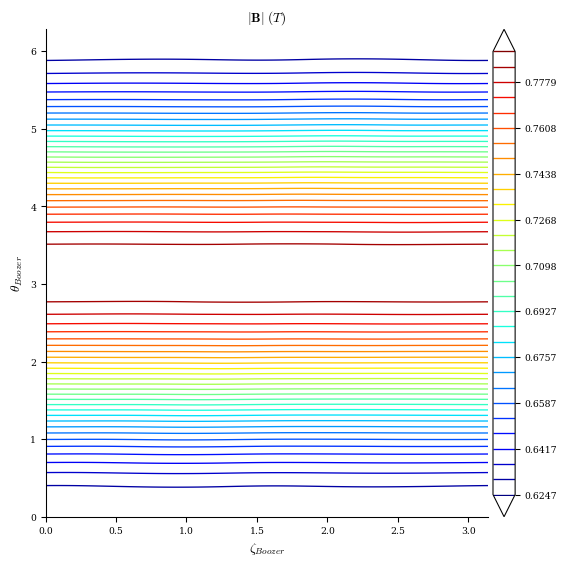

In [10]:
from desc.plotting import plot_boozer_surface

plot_boozer_surface(eq)